# Chapter 5 - Basic Feature Engineering Time

Time Series data must be re-framed as a supervised learning dataset before we can start using machine learning algorithms. There is no concept of input and output features in time series. Instead, we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps.

After completing this tutorial, you will know:
- The rationale and goals of `feature engineering` time series data.
- How to develop basic date-time based input features.
- How to develop more `sophisticated lag` and `sliding window` summary statistics features.

## 5.1 Feature Engineering for Time Series

A time series dataset must be transformed to be modeled as a supervised learning problem.

That is something that looks like:

- time 1, value 1
- time 2, value 2
- time 3, value 3

To something that looks like:

- input 1, output 1
- input 2, output 2
- input 3, output 3

We will look at three classes of features that we can create from our time series dataset:

- **Date Time Features**: these are components of the `time step itself` for each observation.
- **Lag Features**: these are values at `prior time steps`.
- **Window Features**: these are a summary of values over a `fixed window of prior time steps`.

## 5.2 Goal of Feature Engineering

The goal of feature engineering is to provide strong and ideally simple relationships between new input features and the output feature for the supervised learning algorithm to model.

## 5.3 Minimum Daily Temperatures Dataset

we will use the Minimum Daily Temperatures dataset as an example. This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

## 5.4 Date Time Features

These are features from the date/time of each observation. Two features that we can start with are he integer month and day for each observation.

In [1]:
# create date time features of a dataset
from pandas import read_csv
from pandas import DataFrame

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

print(type(series))
print(series.head())

<class 'pandas.core.series.Series'>
Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64


In [2]:
dataframe = DataFrame()
dataframe['month'] = [series.index[i].month for i in range(len(series))]
dataframe['day'] = [series.index[i].day for i in range(len(series))]
dataframe['temperature'] = [series[i] for i in range(len(series))]
#[series.index[i].year for i in range(len(series))]
#[series.index[i].quarter for i in range(len(series))]
print(dataframe.head(5))

month  day  temperature
0      1    1         20.7
1      1    2         17.9
2      1    3         18.8
3      1    4         14.6
4      1    5         15.8


You may enumerate all the properties of a time-stamp and consider what might be useful for your problem, such as:
- Minutes elapsed for the day.
- Hour of day.
- Business hours or not.
- Weekend or not.
- Season of the year.
- Business quarter of the year.
- Daylight savings or not.
- Public holiday or not.
- Leap year or not.

## 5.5 Lag Features

Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems.

The simplest approach is to predict the value at the next time (t+1) given the value at the current time (t). The supervised learning problem with shifted values looks as follows:
- Value(t), Value(t+1)
- Value(t), Value(t+1)
- Value(t), Value(t+1)

The Pandas library provides the shift() function1 to help create these shifted or lag features from a time series dataset. Shifting the dataset by 1 creates the t column, adding a NaN (unknown) value for the first row. The time series dataset without a shift represents the t+1.
- Shifted, Original
- NaN, 20.7
- 20.7, 17.9
- 17.9, 18.8

In [3]:
# create a lag feature
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)
print(series.head(5))

temps = DataFrame(series.values)
print(temps.head(5))

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64
      0
0  20.7
1  17.9
2  18.8
3  14.6
4  15.8


In [4]:
dataframe = concat([temps.shift(1), temps], axis=1)
dataframe.columns = ['t', 't+1']

print(dataframe.head(5))

t   t+1
0   NaN  20.7
1  20.7  17.9
2  17.9  18.8
3  18.8  14.6
4  14.6  15.8


### 5.5.1 Sliding window

In [5]:
# create lag features
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

temps = DataFrame(series.values)

# sliding windows (3)
dataframe = concat([temps.shift(3), temps.shift(2), temps.shift(1), temps], axis=1)
dataframe.columns = ['t-2', 't-1', 't', 't+1']
print(dataframe.head(5))

t-2   t-1     t   t+1
0   NaN   NaN   NaN  20.7
1   NaN   NaN  20.7  17.9
2   NaN  20.7  17.9  18.8
3  20.7  17.9  18.8  14.6
4  17.9  18.8  14.6  15.8


## 5.6 Rolling Window Statistics

**Mean of the previous few values, also called the `rolling mean`.**

A step beyond adding raw lagged values is to add a summary of the values at previous time steps. We can calculate summary statistics across the values in the sliding window and include these as features in our dataset.

First, the series must be shifted. Then the rolling dataset can be created and the mean values calculated on each window of two values.

In [6]:
# create a rolling mean feature
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

temps = DataFrame(series.values)

shifted = temps.shift(1) # serie must be shifted
window = shifted.rolling(window=2) # create rolling data
means = window.mean() # calculate mean for each windows of 2 values

dataframe = concat([means, temps], axis=1)
dataframe.columns = ['mean(t-1,t)', 't+1']
print(dataframe.head(5))

mean(t-1,t)   t+1
0          NaN  20.7
1          NaN  17.9
2        19.30  18.8
3        18.35  14.6
4        16.70  15.8


In [7]:
# validate
print("{:.2f}".format((20.7+17.9)/2))
print("{:.2f}".format((17.9+18.8)/2))
print("{:.2f}".format((18.8+14.6)/2))

19.30
18.35
16.70


In [8]:
# create rolling statistics features
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)
temps = DataFrame(series.values)

# Next, we need to calculate the window statistics with 3 values per window. 
# It takes 3 rows before we even have enough data from the series in the 
# window to start calculating statistics.
width = 3

shifted = temps.shift(width - 1)
window = shifted.rolling(window=width)

dataframe = concat([window.min(), window.mean(), window.max(), temps], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']
print(dataframe.head(10))

min       mean   max   t+1
0   NaN        NaN   NaN  20.7
1   NaN        NaN   NaN  17.9
2   NaN        NaN   NaN  18.8
3   NaN        NaN   NaN  14.6
4  17.9  19.133333  20.7  15.8
5  14.6  17.100000  18.8  15.8
6  14.6  16.400000  18.8  15.8
7  14.6  15.400000  15.8  17.4
8  15.8  15.800000  15.8  21.8
9  15.8  16.333333  17.4  20.0


In [9]:
# validate
print("{:.2f}".format((20.7+17.9+18.8)/width))
print("{:.2f}".format((17.9+18.8+14.6)/width))
print("{:.2f}".format((18.8+14.6+15.8)/width))

19.13
17.10
16.40


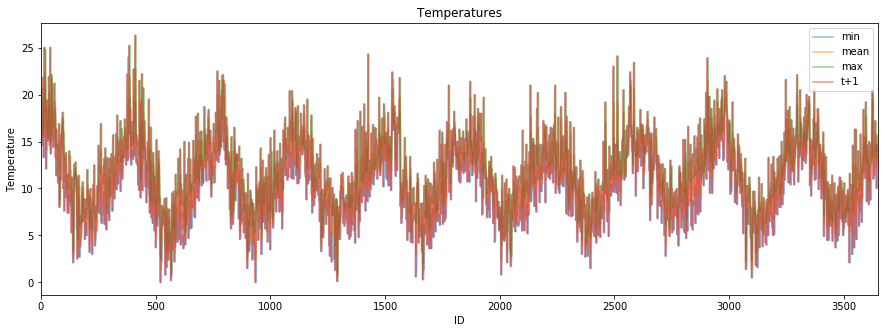

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

_=dataframe.plot(
    figsize=(15,5),
    subplots=False,   ## subplots=True,
    title='Temperatures',
    alpha=0.5
)
_=plt.xlabel('ID')
_=plt.ylabel('Temperature')

## 5.7 Expanding Window Statistics

Another type of window that may be useful includes all previous data in the series. This is called an expanding window and can help with keeping track of the bounds of observable data.

For example, below are the lists of numbers in the expanding window for the first 5 time steps of the series:

- #, Window Values
- 1, 20.7
- 2, 20.7, 17.9,
- 3, 20.7, 17.9, 18.8
- 4, 20.7, 17.9, 18.8, 14.6
- 5, 20.7, 17.9, 18.8, 14.6, 15.8

In [11]:
# create expanding window features
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

csvfile = '.\\code\chapter_05\daily-minimum-temperatures.csv'

series = read_csv(csvfile, header=0, index_col=0, parse_dates=True, squeeze=True)

temps = DataFrame(series.values)
window = temps.expanding()

dataframe = concat([window.min(), window.mean(), window.max(), temps.shift(-1)], axis=1)
dataframe.columns = ['min', 'mean', 'max', 't+1']

print(dataframe.head(5))

min       mean   max   t+1
0  20.7  20.700000  20.7  17.9
1  17.9  19.300000  20.7  18.8
2  17.9  19.133333  20.7  14.6
3  14.6  18.000000  20.7  15.8
4  14.6  17.560000  20.7  15.8


In [12]:
# validate
print("{:.2f}".format((20.7)/1))
print("{:.2f}".format((20.7+17.9)/2))
print("{:.2f}".format((20.7+17.9+18.8)/3))
print("{:.2f}".format((20.7+17.9+18.8+14.6)/4))
print("{:.2f}".format((20.7+17.9+18.8+14.6+15.8)/5))

20.70
19.30
19.13
18.00
17.56


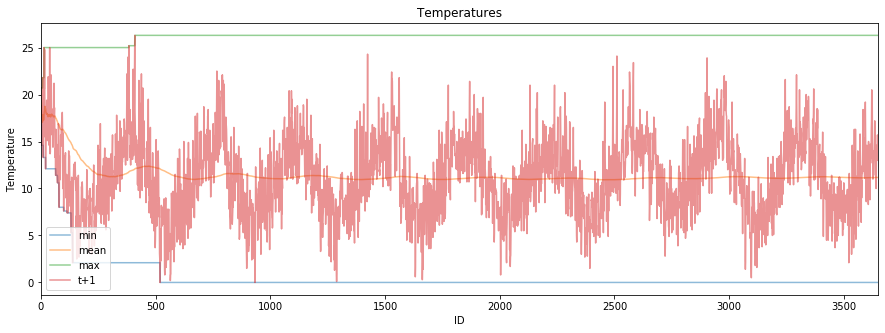

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

_=dataframe.plot(
    figsize=(15,5),
    subplots=False,   ## subplots=True,
    title='Temperatures',
    alpha=0.5
)
_=plt.xlabel('ID')
_=plt.ylabel('Temperature')

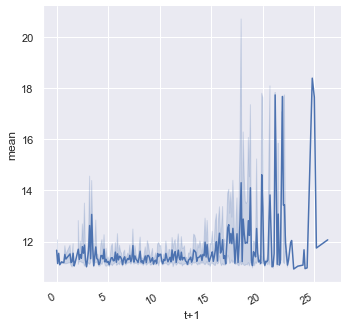

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

g = sns.relplot(x="t+1", y="mean", kind="line", data=dataframe)
g.fig.autofmt_xdate()